# Capstone Project for the Data Science Specialization

### Rafael Y. Imai - April 2021

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.cluster import KMeans
!pip install unidecode
#!pip install wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import seaborn as sns
import unidecode

Also, let's load a dataset with all of the investment funds that have existed since the early 90's in Brazil. This file was also obtained from CVM.

In [25]:
#firstFundFilterLayer = fundList[((fundList["TP_FUNDO"]=="FI")
#                                 &(((fundList["DT_REG"]<="2017-01-01")&((fundList["DT_CANCEL"]>="2020-12-31")))
#                                   |((fundList["DT_REG"]<="2017-01-01")&(fundList["SIT"]=="EM FUNCIONAMENTO NORMAL"))))]
fundList = pd.read_excel("cad_fi.xlsx")


firstFundFilterLayer = fundList[fundList["TP_FUNDO"]=="FI"]
firstFundFilterLayer = firstFundFilterLayer[firstFundFilterLayer["DT_REG"]<"2017-01-01"]
firstFundFilterLayer = firstFundFilterLayer[(firstFundFilterLayer["SIT"]=="EM FUNCIONAMENTO NORMAL")]
firstFundFilterLayer = firstFundFilterLayer.drop_duplicates(subset=['CNPJ_FUNDO'], keep='last')
         

#### Another dataset that we will use is the historic series of the IBOVESPA index, the stock market index for the São Paulo Stock Exchange.

In [26]:
insightsHedgeFund_Dump=pd.read_csv("hedgeFund_dump_2017-01-01-2020-12-31.csv")
insightsFI_Dump=pd.read_csv("fixedIncome_dump_2017-01-01-2020-12-31.csv")


In [27]:
insightsHedgeFund_Dump=insightsHedgeFund_Dump[['CNPJ','IbovCorrelation','SELICCorrelation','flowCorrelation','avgTicketCorrelation','vol']]
insightsFI_Dump=insightsFI_Dump[['CNPJ','IbovCorrelation','SELICCorrelation','flowCorrelation','avgTicketCorrelation','vol']]

insightsHedgeFund_Dump=insightsHedgeFund_Dump.set_index("CNPJ")
insightsFI_Dump=insightsFI_Dump.set_index("CNPJ") 

In [46]:
def plot_wordcloud(parsed, clusterCount, graphTitle,stopwordsClass):

    stopwords = set(STOPWORDS)
    stopwords.update(["INVESTIMENTO", "COTAS", "QUOTAS", "DE", "FUNDO", "FEEDER", "EM", "FDO", "INV", "FDOS", 
                      "INVES","FUNDOS","FICFI","FI","FUND"])
    stopwords.update(stopwordsClass)


    for i in range(0,clusterCount):    
        consolidated = parsed[parsed['resultKmeans']==i]
        consolidated = consolidated['DENOM_SOCIAL']

        text = ""
        for a in consolidated:
            text = text + " " + a
        
        text = unidecode.unidecode(text)
        text = text.replace(" LP ", " LONGO PRAZO ")
        text = text.replace(" CRED PRIV ", " CREDITO PRIVADO ")

        wordcloud = WordCloud(stopwords=stopwords,max_font_size=50, max_words=20, background_color="white").generate(text)
        plt.figure()
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.title("{} - Cluster #{}".format(graphTitle,i+1))
        plt.savefig("{}_{}.png".format(graphTitle,i+1))
        plt.show()

In [29]:
def test_kmeans(maxClusters,data):

    wcss=[]

    for i in range(1,maxClusters):
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
        kmeans.fit(data[['IbovCorrelation','SELICCorrelation','flowCorrelation','avgTicketCorrelation','vol']].dropna())    
        wcss = wcss + [kmeans.inertia_] 
    plt.plot(range(1,20),wcss) 
    
    
    

In [30]:
def run_kmeans(clusterCount,data):

    kmeans = KMeans(n_clusters=clusterCount, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(data[['IbovCorrelation','SELICCorrelation','flowCorrelation','avgTicketCorrelation','vol']].dropna())

    k_means_labels = kmeans.labels_
    k_means_cluster_centers = kmeans.cluster_centers_

    print("Centroids:")
    print(k_means_cluster_centers)

    return k_means_labels, k_means_cluster_centers


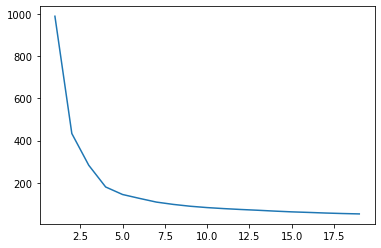

In [31]:
test_kmeans(20,insightsHedgeFund_Dump)

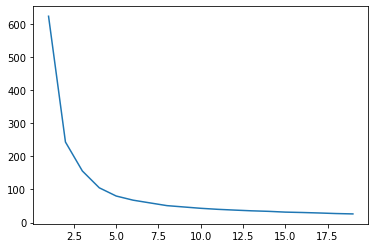

In [32]:
test_kmeans(20,insightsFI_Dump)

In [33]:
stopwordsClassHedgeFund = ['MULTIMERCADO','FIM','ADVISORY']
clusterCountHedgeFund = 4
k_means_labels_HedgeFund, k_means_cluster_centers_HedgeFund = run_kmeans(clusterCountHedgeFund, insightsHedgeFund_Dump)

stopwordsFI = ['RF','RENDA FIXA', 'RENDA', 'FIXA','ADVISORY','FIRF']
clusterCountFI = 4
k_means_labels_FI, k_means_cluster_centers_FI = run_kmeans(clusterCountFI, insightsFI_Dump)



Centroids:
[[-0.55495904  0.62412754  0.01076104 -0.71091126  0.10418737]
 [ 0.51374432 -0.66194098  0.01201196 -0.59960554  0.11064485]
 [-0.64285821  0.57461429 -0.00352217  0.49621998  0.08287944]
 [ 0.56964001 -0.72146429 -0.00498463  0.57782624  0.09646134]]
Centroids:
[[ 0.30037208 -0.6076218  -0.01370009  0.44337376  0.07529   ]
 [-0.71052642  0.74681207 -0.02677965  0.69797631  0.06191241]
 [ 0.57666149 -0.72000184 -0.02745897 -0.56606888  0.08073278]
 [-0.6698499   0.64047355  0.00475802 -0.52343021  0.06253608]]


In [34]:
def print_wordcloud(dataSource,k_means_labels,clusterCount,title,stopwordsClass):
    transposed = pd.DataFrame(data=k_means_labels)
    parsed = dataSource.dropna().reset_index().join(transposed)
    parsed = parsed.set_index("CNPJ")
    parsed = parsed.rename(columns={0:"resultKmeans"})
    lista_interpretada = firstFundFilterLayer[["CNPJ_FUNDO","DENOM_SOCIAL"]].set_index("CNPJ_FUNDO")
    lista_interpretada=lista_interpretada.reset_index().rename(columns={"CNPJ_FUNDO":"CNPJ"}).set_index("CNPJ") 
    parsed = parsed.join(lista_interpretada) 
    plot_wordcloud(parsed, clusterCount, title,stopwordsClass)
    print("{} Shape".format(title))
    print(parsed.shape)
 

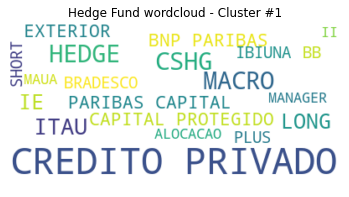

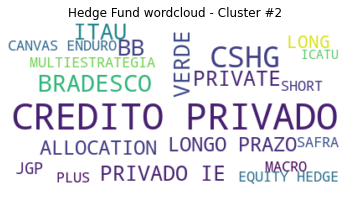

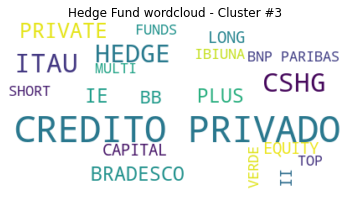

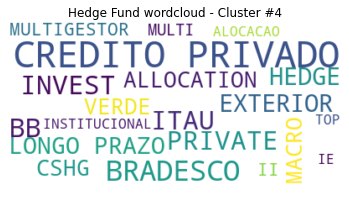

Hedge Fund wordcloud Shape
(798, 7)


In [47]:
print_wordcloud(insightsHedgeFund_Dump,k_means_labels_FI,clusterCountHedgeFund,"Hedge Fund wordcloud",stopwordsClassHedgeFund)

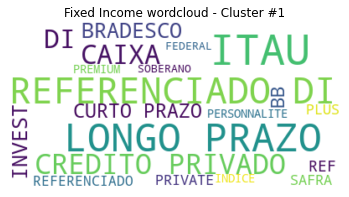

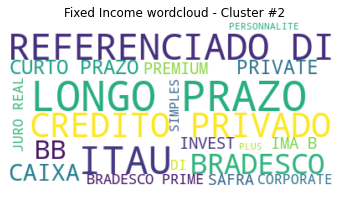

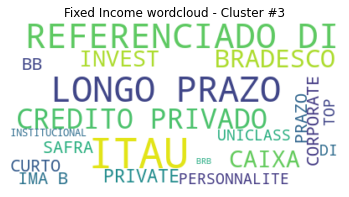

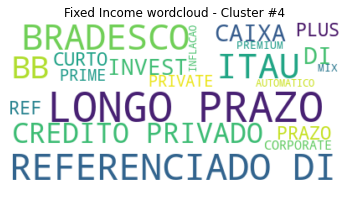

Fixed Income wordcloud Shape
(452, 7)


In [48]:
print_wordcloud(insightsFI_Dump,k_means_labels_HedgeFund,clusterCountFI,"Fixed Income wordcloud",stopwordsFI)

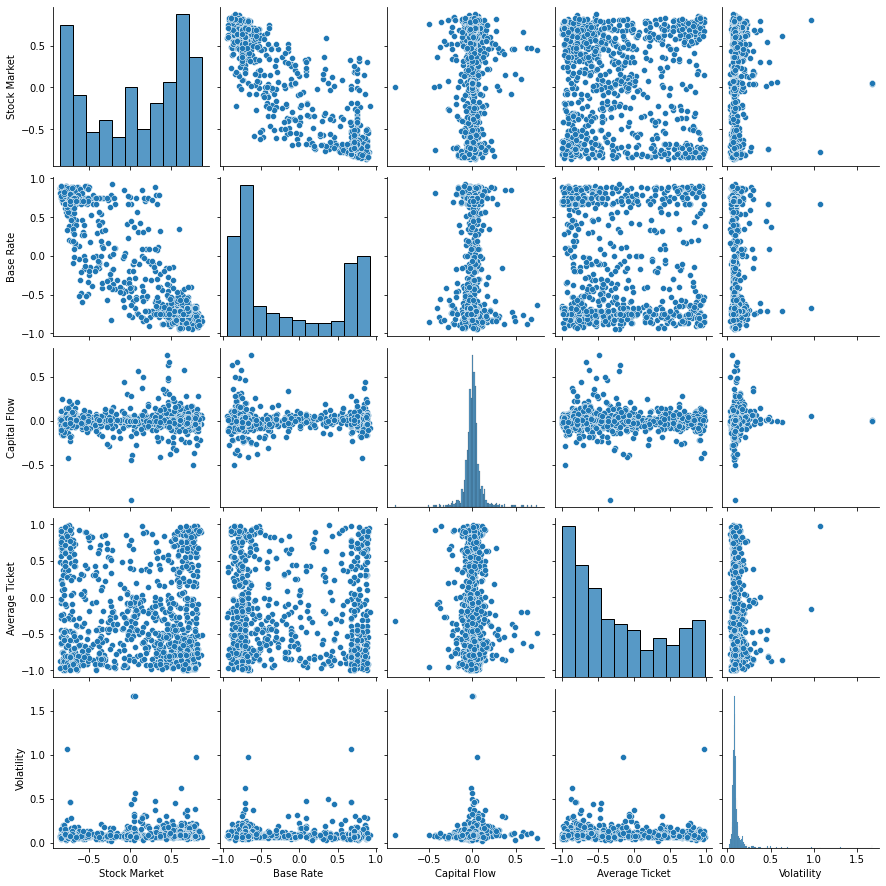

In [55]:
plot = sns.pairplot(insightsHedgeFund_Dump.rename(columns={'IbovCorrelation':'Stock Market','SELICCorrelation':'Base Rate','flowCorrelation':'Capital Flow','vol':'Volatility','avgTicketCorrelation':'Average Ticket',}))
plot.savefig("pairplot_HedgeFund.png")

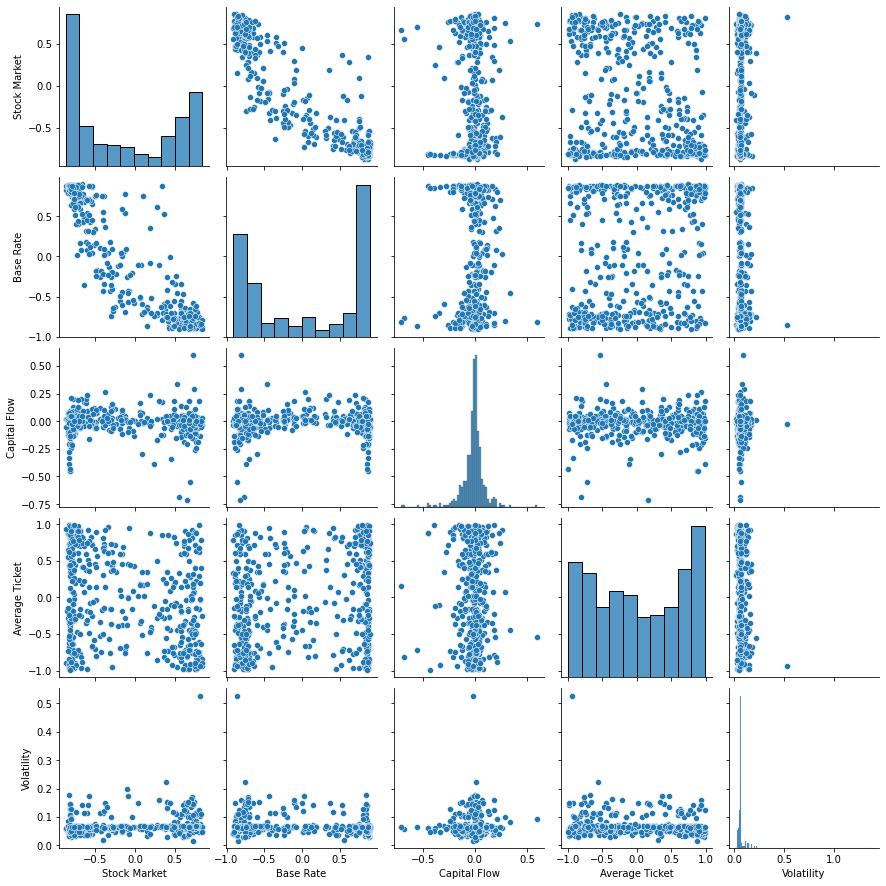

In [56]:
plot = sns.pairplot(insightsFI_Dump.rename(columns={'IbovCorrelation':'Stock Market','SELICCorrelation':'Base Rate','flowCorrelation':'Capital Flow','vol':'Volatility','avgTicketCorrelation':'Average Ticket',}))
plot.savefig("pairplot_FixedIncome.png")